In [2]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import yaml
import subprocess
import os

import runMops
import MopsAnalysis
import MopsReader
import MopsPlotter
from MopsTracker import MopsTracker
from MopsParameters import MopsParameters
from MopsResults import MopsResults

% matplotlib inline

In [3]:
dataDrive = "/Volumes/DataCenter/"
dataLocation = "neosimData/jpl/oc28-30EditedSSMIDs.txt"
subsampleLocation = "neosimData/jpl_2016_03_24_MaxAccel100/"
runLocation = dataDrive + subsampleLocation

In [4]:
parameters = MopsParameters.fromYaml(runLocation + "parameters.yaml")
tracker = MopsTracker.fromYaml(runLocation + "tracker.yaml")

Loading parameters from /Volumes/DataCenter/neosimData/jpl_2016_03_24_MaxAccel100/parameters.yaml
Loading tracker from /Volumes/DataCenter/neosimData/jpl_2016_03_24_MaxAccel100/tracker.yaml


In [5]:
results = MopsResults.fromYaml(runLocation + "results.yaml")

Loading results from /Volumes/DataCenter/neosimData/jpl_2016_03_24_MaxAccel100/results.yaml


In [6]:
import MopsDatabase
import MopsPlotter

In [7]:
con = sql.connect(tracker.mainDatabase)
window_dbs = MopsDatabase.attachDatabases(con, tracker.windowDatabases)

Proceeding with the first 10 databases...
Attaching /Volumes/DataCenter/neosimData/jpl_2016_03_24_MaxAccel100/results/52391-52406.db to con as db0...
Attaching /Volumes/DataCenter/neosimData/jpl_2016_03_24_MaxAccel100/results/52392-52406.db to con as db1...
Attaching /Volumes/DataCenter/neosimData/jpl_2016_03_24_MaxAccel100/results/52393-52408.db to con as db2...
Attaching /Volumes/DataCenter/neosimData/jpl_2016_03_24_MaxAccel100/results/52394-52408.db to con as db3...
Attaching /Volumes/DataCenter/neosimData/jpl_2016_03_24_MaxAccel100/results/52395-52410.db to con as db4...
Attaching /Volumes/DataCenter/neosimData/jpl_2016_03_24_MaxAccel100/results/52396-52411.db to con as db5...
Attaching /Volumes/DataCenter/neosimData/jpl_2016_03_24_MaxAccel100/results/52397-52412.db to con as db6...
Attaching /Volumes/DataCenter/neosimData/jpl_2016_03_24_MaxAccel100/results/52398-52413.db to con as db7...
Attaching /Volumes/DataCenter/neosimData/jpl_2016_03_24_MaxAccel100/results/52399-52413.db to 

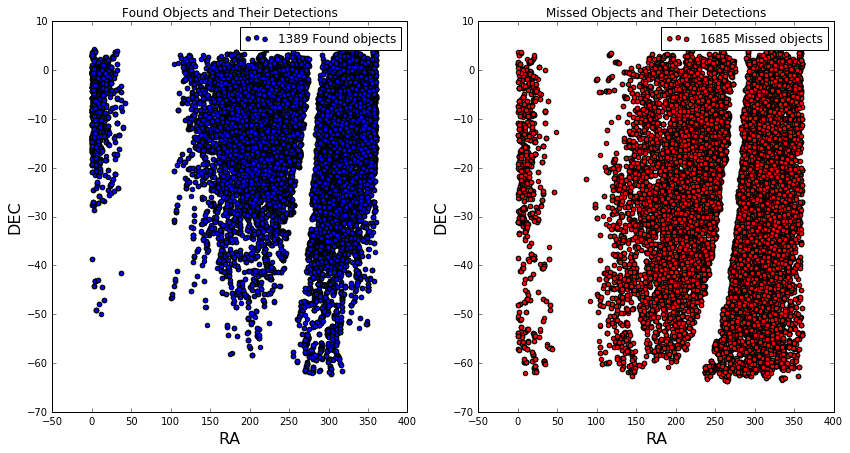

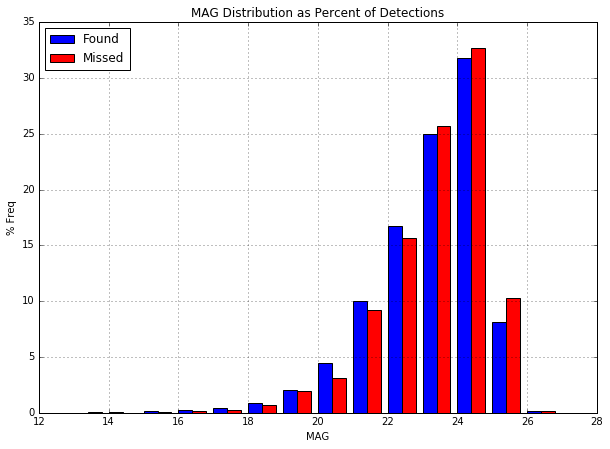

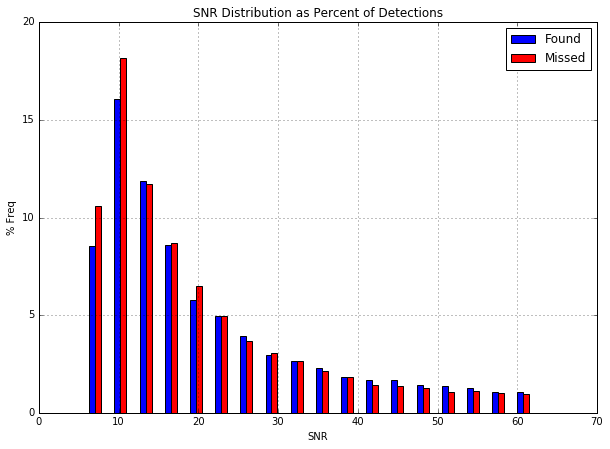

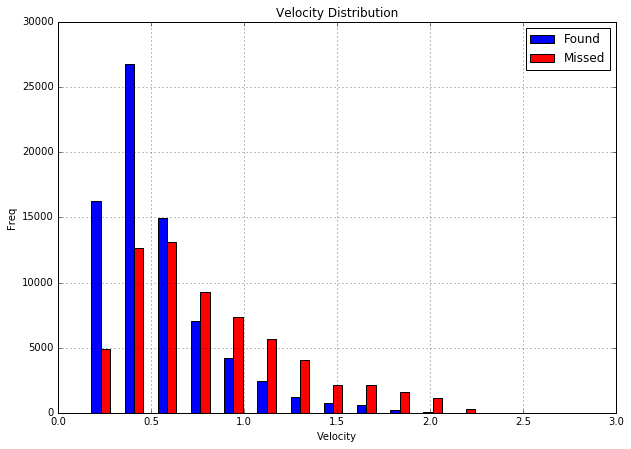

In [20]:
missed_objects = pd.read_sql("""SELECT objectId FROM AllObjects
                                    WHERE findableAsTrack = 1
                                    AND numTrueTracks = 0""", con)["objectId"].values
found_objects = pd.read_sql("""SELECT objectId FROM AllObjects
                                    WHERE findableAsTrack = 1
                                    AND numTrueTracks >= 1""", con)["objectId"].values

missed_objects_detections = MopsDatabase.findDetectionsWithObjectIds(con, missed_objects)
found_objects_detections = MopsDatabase.findDetectionsWithObjectIds(con, found_objects)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(14,7)

ax[0].scatter(found_objects_detections["ra"], found_objects_detections["dec"], c="b", label="%s Found objects" % len(found_objects))
ax[1].scatter(missed_objects_detections["ra"], missed_objects_detections["dec"], c="r",  label="%s Missed objects" % len(missed_objects))

for a in ax:
    a.legend()
    a.set_xlabel("RA", size=16);
    a.set_ylabel("DEC", size=16);   
    
ax[0].set_title("Found Objects and Their Detections")
ax[1].set_title("Missed Objects and Their Detections")

hist, bin_edges = np.histogram(found_objects_detections["mag"].values, bins=np.linspace(12,26,15))
hist2, bins = np.histogram(missed_objects_detections["mag"].values, bins=bin_edges)
width = 0.4

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,7)
ax.bar(bin_edges[1:], hist/float(len(found_objects_detections))*100.0, width, label="Found")
ax.bar(bin_edges[1:] + width, hist2/float(len(missed_objects_detections))*100.0, width, color="r", label="Missed")
#ax.set_xticks(bin_edges[1:]);
ax.legend(loc="upper left");
ax.grid();
ax.set_title("MAG Distribution as Percent of Detections");
ax.set_xlabel("MAG");
ax.set_ylabel("% Freq");

hist, bin_edges = np.histogram(found_objects_detections["snr"].values, bins=np.linspace(0,60,20))
hist2, bins = np.histogram(missed_objects_detections["snr"].values, bins=bin_edges)
width = 0.75

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,7)
ax.bar(bin_edges[1:], hist/float(len(found_objects_detections))*100.0, width, label="Found")
ax.bar(bin_edges[1:] + width, hist2/float(len(missed_objects_detections))*100.0, width, color="r", label="Missed")
#ax.set_xticks(bin_edges[1:]);
ax.legend(loc="upper right");
ax.grid();
ax.set_title("SNR Distribution as Percent of Detections");
ax.set_xlabel("SNR");
ax.set_ylabel("% Freq");

missed_objects_velocities = pd.read_sql("""SELECT AllTracklets.trackletId, DiaSources.objectId, trackletMembers.diaId, ra, dec, velocity, rms, findableAsTrack, numTrueTracks FROM AllTracklets
                                             JOIN TrackletMembers ON
                                                AllTracklets.trackletId = TrackletMembers.trackletId
                                            JOIN DiaSources ON
                                                TrackletMembers.diaId = DiaSources.diaId
                                            JOIN AllObjects ON
                                                DiaSources.objectId = AllObjects.objectId
                                            WHERE findableAsTrack = 1
                                            AND numTrueTracks = 0;
                                            """, con)
found_objects_velocities = pd.read_sql("""SELECT AllTracklets.trackletId, DiaSources.objectId, trackletMembers.diaId, ra, dec, velocity, rms, findableAsTrack, numTrueTracks FROM AllTracklets
                                             JOIN TrackletMembers ON
                                                AllTracklets.trackletId = TrackletMembers.trackletId
                                            JOIN DiaSources ON
                                                TrackletMembers.diaId = DiaSources.diaId
                                            JOIN AllObjects ON
                                                DiaSources.objectId = AllObjects.objectId
                                            WHERE findableAsTrack = 1
                                            AND numTrueTracks >= 1 ;
                                            """, con)

hist, bin_edges = np.histogram(found_objects_velocities["velocity"].values, bins=np.linspace(0,2.5,15))
hist2, bins = np.histogram(missed_objects_velocities["velocity"].values, bins=bin_edges)
width = 0.05

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,7)
ax.bar(bin_edges[1:], hist, width, label="Found")
ax.bar(bin_edges[1:] + width, hist2, width, color="r", label="Missed")
ax.legend(loc="upper right");
ax.grid();
ax.set_title("Velocity Distribution");
ax.set_xlabel("Velocity");
ax.set_ylabel("Freq");

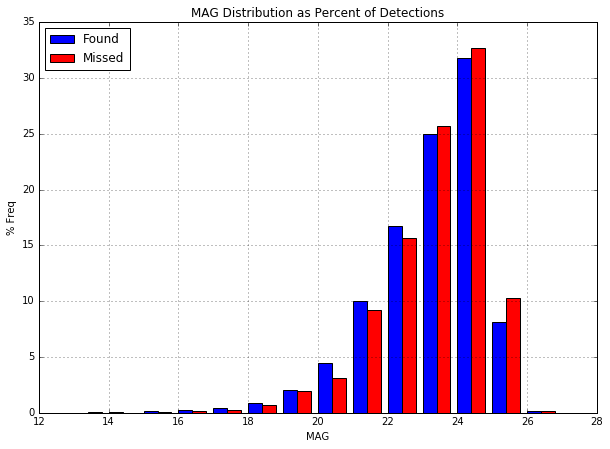

In [15]:
hist, bin_edges = np.histogram(found_objects_detections["mag"].values, bins=np.linspace(12,26,15))
hist2, bins = np.histogram(missed_objects_detections["mag"].values, bins=bin_edges)
width = 0.4

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,7)
ax.bar(bin_edges[1:], hist/float(len(found_objects_detections))*100.0, width, label="Found")
ax.bar(bin_edges[1:] + width, hist2/float(len(missed_objects_detections))*100.0, width, color="r", label="Missed")
#ax.set_xticks(bin_edges[1:]);
ax.legend(loc="upper left");
ax.grid();
ax.set_title("MAG Distribution as Percent of Detections");
ax.set_xlabel("MAG");
ax.set_ylabel("% Freq");

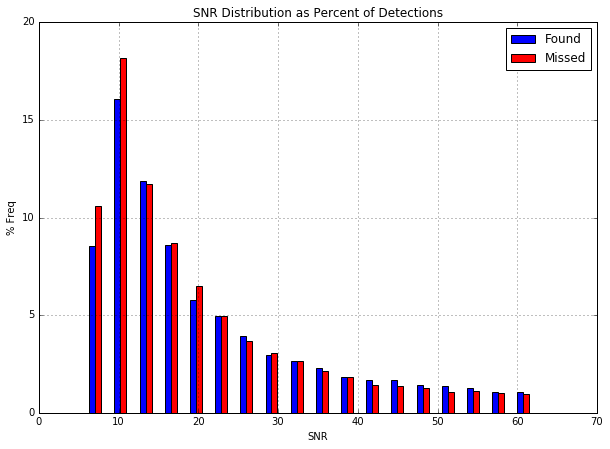

In [16]:
hist, bin_edges = np.histogram(found_objects_detections["snr"].values, bins=np.linspace(0,60,20))
hist2, bins = np.histogram(missed_objects_detections["snr"].values, bins=bin_edges)
width = 0.75

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,7)
ax.bar(bin_edges[1:], hist/float(len(found_objects_detections))*100.0, width, label="Found")
ax.bar(bin_edges[1:] + width, hist2/float(len(missed_objects_detections))*100.0, width, color="r", label="Missed")
#ax.set_xticks(bin_edges[1:]);
ax.legend(loc="upper right");
ax.grid();
ax.set_title("SNR Distribution as Percent of Detections");
ax.set_xlabel("SNR");
ax.set_ylabel("% Freq");

In [17]:
missed_objects_velocities = pd.read_sql("""SELECT AllTracklets.trackletId, DiaSources.objectId, trackletMembers.diaId, ra, dec, velocity, rms, findableAsTrack, numTrueTracks FROM AllTracklets
                                             JOIN TrackletMembers ON
                                                AllTracklets.trackletId = TrackletMembers.trackletId
                                            JOIN DiaSources ON
                                                TrackletMembers.diaId = DiaSources.diaId
                                            JOIN AllObjects ON
                                                DiaSources.objectId = AllObjects.objectId
                                            WHERE findableAsTrack = 1
                                            AND numTrueTracks = 0;
                                            """, con)
found_objects_velocities = pd.read_sql("""SELECT AllTracklets.trackletId, DiaSources.objectId, trackletMembers.diaId, ra, dec, velocity, rms, findableAsTrack, numTrueTracks FROM AllTracklets
                                             JOIN TrackletMembers ON
                                                AllTracklets.trackletId = TrackletMembers.trackletId
                                            JOIN DiaSources ON
                                                TrackletMembers.diaId = DiaSources.diaId
                                            JOIN AllObjects ON
                                                DiaSources.objectId = AllObjects.objectId
                                            WHERE findableAsTrack = 1
                                            AND numTrueTracks >= 1 ;
                                            """, con)

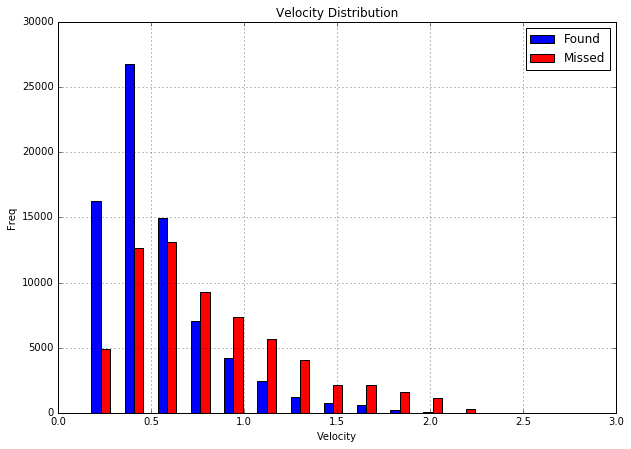

In [19]:
hist, bin_edges = np.histogram(found_objects_velocities["velocity"].values, bins=np.linspace(0,2.5,15))
hist2, bins = np.histogram(missed_objects_velocities["velocity"].values, bins=bin_edges)
width = 0.05

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,7)
ax.bar(bin_edges[1:], hist, width, label="Found")
ax.bar(bin_edges[1:] + width, hist2, width, color="r", label="Missed")
ax.legend(loc="upper right");
ax.grid();
ax.set_title("Velocity Distribution");
ax.set_xlabel("Velocity");
ax.set_ylabel("Freq");

In [112]:
tracklets_of_missed_objects = pd.read_sql("""SELECT AllTracklets.trackletId, DiaSources.objectId, trackletMembers.diaId, ra, dec, velocity, rms, findableAsTrack, numTrueTracks FROM AllTracklets
                                             JOIN TrackletMembers ON
                                                AllTracklets.trackletId = TrackletMembers.trackletId
                                            JOIN DiaSources ON
                                                TrackletMembers.diaId = DiaSources.diaId
                                            JOIN AllObjects ON
                                                DiaSources.objectId = AllObjects.objectId
                                            WHERE findableAsTrack = 1
                                            AND numTrueTracks = 0;
                                            """, con)
tracklets_of_found_objects = pd.read_sql("""SELECT AllTracklets.trackletId, DiaSources.objectId, trackletMembers.diaId, ra, dec, velocity, rms, findableAsTrack, numTrueTracks FROM AllTracklets
                                             JOIN TrackletMembers ON
                                                AllTracklets.trackletId = TrackletMembers.trackletId
                                            JOIN DiaSources ON
                                                TrackletMembers.diaId = DiaSources.diaId
                                            JOIN AllObjects ON
                                                DiaSources.objectId = AllObjects.objectId
                                            WHERE findableAsTrack = 1
                                            AND numTrueTracks >= 1 ;
                                            """, con)
all_tracklets = pd.read_sql("""SELECT AllTracklets.trackletId, DiaSources.objectId, trackletMembers.diaId, ra, dec, velocity, rms, findableAsTrack, numTrueTracks FROM AllTracklets
                                             JOIN TrackletMembers ON
                                                AllTracklets.trackletId = TrackletMembers.trackletId
                                            JOIN DiaSources ON
                                                TrackletMembers.diaId = DiaSources.diaId
                                            JOIN AllObjects ON
                                                DiaSources.objectId = AllObjects.objectId;
                                            """, con)

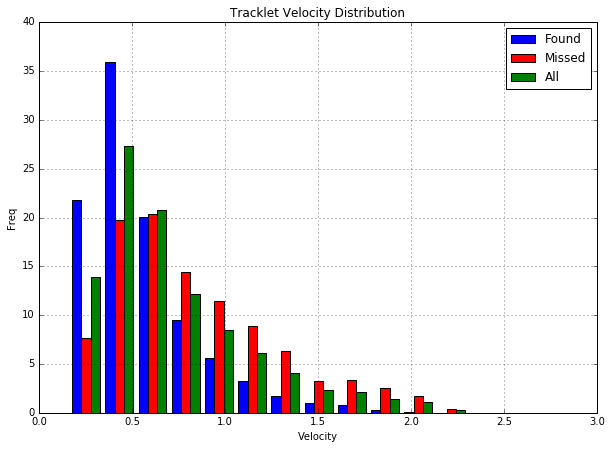

In [139]:
hist, bin_edges = np.histogram(tracklets_of_found_objects["velocity"].values, bins=np.linspace(0,2.5,15))
hist2, bins = np.histogram(tracklets_of_missed_objects["velocity"].values, bins=bin_edges)
hist3, bins = np.histogram(all_tracklets["velocity"].values, bins=bin_edges)
width = 0.05

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,7)
ax.bar(bin_edges[1:], hist, width, label="Found")
ax.bar(bin_edges[1:] + width, hist2, width, color="r", label="Missed")
ax.bar(bin_edges[1:] + 2*width, hist3, width, color="g", label="All")

#ax.set_xticks(bin_edges[1:]);
ax.legend(loc="upper right");
ax.grid();
ax.set_title("Tracklet Velocity Distribution");
ax.set_xlabel("Velocity");
ax.set_ylabel("Freq");

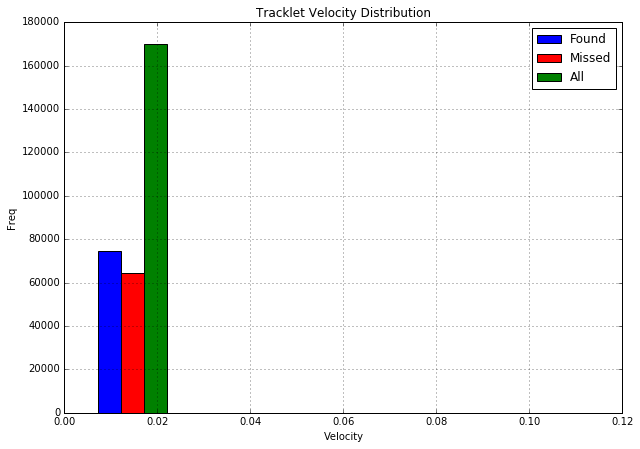

In [123]:
hist, bin_edges = np.histogram(tracklets_of_found_objects["rms"].values, bins=np.linspace(0,0.1,15))
hist2, bins = np.histogram(tracklets_of_missed_objects["rms"].values, bins=bin_edges)
hist3, bins = np.histogram(all_tracklets["rms"].values, bins=bin_edges)
width = 0.005

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,7)
ax.bar(bin_edges[1:], hist, width, label="Found")
ax.bar(bin_edges[1:] + width, hist2, width, color="r", label="Missed")
ax.bar(bin_edges[1:] + 2*width, hist3, width, color="g", label="All")

#ax.set_xticks(bin_edges[1:]);
ax.legend(loc="upper right");
ax.grid();
ax.set_title("Tracklet Velocity Distribution");
ax.set_xlabel("Velocity");
ax.set_ylabel("Freq");

In [124]:
purified_tracklets = pd.read_sql("""SELECT AllTracklets.trackletId, DiaSources.objectId, trackletMembers.diaId, ra, dec, velocity, rms, findableAsTrack, numTrueTracks FROM AllTracklets
                                             JOIN TrackletMembers ON
                                                AllTracklets.trackletId = TrackletMembers.trackletId
                                            JOIN DiaSources ON
                                                TrackletMembers.diaId = DiaSources.diaId
                                            JOIN AllObjects ON
                                                DiaSources.objectId = AllObjects.objectId
                                            WHERE allTracklets.createdBy = 3
                                            """, con)
collapsed_tracklets = pd.read_sql("""SELECT AllTracklets.trackletId, DiaSources.objectId, trackletMembers.diaId, ra, dec, velocity, rms, findableAsTrack, numTrueTracks FROM AllTracklets
                                             JOIN TrackletMembers ON
                                                AllTracklets.trackletId = TrackletMembers.trackletId
                                            JOIN DiaSources ON
                                                TrackletMembers.diaId = DiaSources.diaId
                                            JOIN AllObjects ON
                                                DiaSources.objectId = AllObjects.objectId
                                            WHERE allTracklets.createdBy = 2
                                            """, con)
all_tracklets = pd.read_sql("""SELECT AllTracklets.trackletId, DiaSources.objectId, trackletMembers.diaId, ra, dec, velocity, rms, findableAsTrack, numTrueTracks FROM AllTracklets
                                             JOIN TrackletMembers ON
                                                AllTracklets.trackletId = TrackletMembers.trackletId
                                            JOIN DiaSources ON
                                                TrackletMembers.diaId = DiaSources.diaId
                                            JOIN AllObjects ON
                                                DiaSources.objectId = AllObjects.objectId;
                                            """, con)

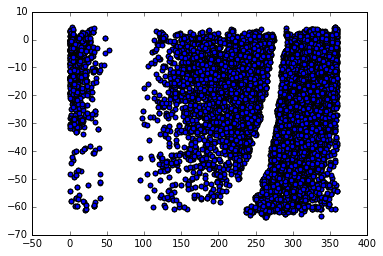

In [128]:
fig, ax = plt.subplots(1,1)
ax.scatter(collapsed_tracklets["ra"], collapsed_tracklets["dec"])

In [36]:
def arrayToSqlQuery(array):
    sample = ""
    for i in array:
        sample += str(i) + ', '

    sample = '(' + sample[0:-2] + ')'
    return sample

def findTrackletMembers(con, trackletId):
    diaids = pd.read_sql("""SELECT diaId FROM TrackletMembers
                            WHERE trackletId = %s""" % (trackletId), con)
    return diaids

def findTrackMembers(con, trackId, window):
    diaids = pd.read_sql("""SELECT diaId FROM %s.TrackMembers
                            WHERE trackId = %s""" % (window, trackId), con)
    return diaids

def findDetections(con, diaids):
    diaids_query = arrayToSqlQuery(diaids)
    detections = pd.read_sql("""SELECT * FROM DiaSources
                                WHERE diaId IN %s""" % diaids_query, con)
    return detections

def findDetectionsWithObjectId(con, objectId):
    detections = pd.read_sql("""SELECT * FROM DiaSources
                                WHERE objectId = %s""" % objectId, con)
    return detections

def findDetectionsWithObjectIds(con, objectIds):
    detections = pd.read_sql("""SELECT * FROM DiaSources
                                WHERE objectId IN %s""" % arrayToSqlQuery(objectIds), con)
    return detections

def findNearbyDetections(con, ra0, dec0, ra1, dec1, night, windowSize=1):
    night_min = night
    night_max = night_min + windowSize
    
    nearby_detections = pd.read_sql_query("""SELECT * FROM DiaSources
                                            WHERE (mjd BETWEEN %f AND %f) AND (dec BETWEEN %f and %f) AND (ra BETWEEN %f AND %f)
                                            """ % (night_min, night_max, dec0, dec1, ra0, ra1), con)
    return nearby_detections

def findTrackletDetections(con, trackletId):
    diaids = findTrackletMembers(con, trackletId)
    detections = findDetections(con, diaids)
    return detections

def findTrackDetections(con, trackId, window):
    diaids = findTrackMembers(con, trackId, window)
    detections = findDetections(con, diaids)
    return detections

def findTrackletInfo(con, trackletId):
    info = pd.read_sql("""SELECT * FROM AllTracklets
                        WHERE trackletId = %s""" % trackletId, con)
    return info

def findTrackInfo(con, trackId, window):
    info = pd.read_sql("""SELECT * FROM %s.AllTracks
                        WHERE trackId = %s""" % (window, trackId), con)
    return info

def selectFalseTracklets(con):
    falseTracklets = pd.read_sql("""SELECT trackletId FROM AllTracklets
                                    WHERE linkedObjectId = -1""", con)
    return falseTracklets

def selectTrueTracklets(con):
    trueTracklets = pd.read_sql("""SELECT trackletId FROM AllTracklets
                                    WHERE linkedObjectId != -1""", con)
    return trueTracklets

def selectFalseTracks(con, window):
    falseTracks = pd.read_sql("""SELECT trackId FROM %s.AllTracks
                                    WHERE linkedObjectId = -1""" % (window), con)
    return falseTracks

def selectTrueTracks(con, window):
    trueTracks = pd.read_sql("""SELECT trackId FROM %s.AllTracks
                                    WHERE linkedObjectId != -1""" % (window), con)
    return trueTracks

def selectFindableObjectsAsTracklets(con):
    objects = pd.read_sql("""SELECT * FROM AllObjects
                                WHERE findableAsTracklet = 1""", con)
    return objects

def selectFindableObjectsAsTracks(con):
    objects = pd.read_sql("""SELECT * FROM AllObjects
                                WHERE findableAsTrack = 1""", con)
    return objects

def selectFoundObjects(con):
    objects = pd.read_sql("""SELECT * FROM AllObjects
                                WHERE numTrueTracks > 0""", con)
    return objects

def selectMissedObjects(con):
    objects = pd.read_sql("""SELECT * FROM AllObjects
                                WHERE findableAsTrack = 1
                                AND numTrueTracks = 0""", con)
    return objects

def findObjectLinkages(con, objectId, attachedWindows, onlyFalseLinkages=False):
    detections = findDetectionsWithObjectId(con, objectId)
    diaids = detections["diaId"].values

    if onlyFalseLinkages:
        tracklet_ids_all = pd.read_sql("""SELECT DISTINCT trackletId FROM TrackletMembers
                                        WHERE diaId IN %s""" % (arrayToSqlQuery(diaids)), con)["trackletId"].values
        tracklet_ids  = pd.read_sql("""SELECT DISTINCT trackletId FROM AllTracklets
                                    WHERE trackletId IN %s
                                    AND linkedObjectId = -1""" % (arrayToSqlQuery(tracklet_ids_all)), con)["trackletId"].values
        track_ids = {}
        for window in attachedWindows:
            track_ids_window = pd.read_sql("""SELECT DISTINCT trackId FROM %s.TrackMembers
                                                WHERE diaId IN %s""" % (window, arrayToSqlQuery(diaids)), con)["trackId"].values
            false_track_ids_window = pd.read_sql("""SELECT DISTINCT trackId FROM %s.AllTracks
                                                        WHERE trackId IN %s
                                                        AND linkedObjectId = -1""" % (window, arrayToSqlQuery(track_ids_window)), con)["trackId"].values
            track_ids[window] = false_track_ids_window
    else:
        tracklet_ids = pd.read_sql("""SELECT DISTINCT trackletId FROM TrackletMembers
                                        WHERE diaId IN %s""" % (arrayToSqlQuery(diaids)), con)["trackletId"].values
        track_ids = {}
        for window in attachedWindows:
            track_ids_window = pd.read_sql("""SELECT DISTINCT trackId FROM %s.TrackMembers
                                        WHERE diaId IN %s""" % (window, arrayToSqlQuery(diaids)), con)["trackId"].values
            track_ids[window] = track_ids_window 
        
    return tracklet_ids, track_ids

In [133]:
selectMissedObjects(con)

,objectId,numDetections,findableAsTracklet,findableAsTrack,numFalseTracklets,numTrueTracklets,numFalseCollapsedTracklets,numTrueCollapsedTracklets,numFalsePurifiedTracklets,numTruePurifiedTracklets,numFalseFinalTracklets,numTrueFinalTracklets,numFalseTracks,numTrueTracks,numFalseFinalTracks,numTrueFinalTracks
0,5,21,1,1,0,1,0,0,0,0,0,0,0,0,0,0
1,7,8,1,1,0,1,0,0,0,0,0,0,0,0,0,0
2,8,27,1,1,0,13,0,3,0,0,0,0,0,0,0,0
3,9,22,1,1,0,6,0,1,0,0,0,0,0,0,0,0
4,10,23,1,1,0,5,0,0,0,0,0,0,0,0,0,0
5,13,8,1,1,0,2,0,0,0,0,0,0,0,0,0,0
6,17,17,1,1,0,1,0,0,0,0,0,0,0,0,0,0
7,25,9,1,1,0,3,0,0,0,0,0,0,0,0,0,0
8,27,10,1,1,0,0,0,0,0,0,0,0,0,0,0,0
9,28,18,1,1,0,9,0,0,0,0,0,0,0,0,0,0


In [134]:
tracklets = pd.read_sql("""SELECT AllTracklets.trackletId, DiaSources.objectId, trackletMembers.diaId, ra, dec, velocity, rms, findableAsTrack, numTrueTracks FROM AllTracklets
                                             JOIN TrackletMembers ON
                                                AllTracklets.trackletId = TrackletMembers.trackletId
                                            JOIN DiaSources ON
                                                TrackletMembers.diaId = DiaSources.diaId
                                            JOIN AllObjects ON
                                                DiaSources.objectId = AllObjects.objectId;
                                            """, con)

In [135]:
tracklets

,trackletId,objectId,diaId,ra,dec,velocity,rms,findableAsTrack,numTrueTracks
0,1,0,0,176.493376,-11.783686,0.316258,4.611555e-14,1,12
1,1,0,29,176.487141,-11.776941,0.316258,4.611555e-14,1,12
2,2,2,2,174.183623,-2.062412,0.198838,4.693786e-14,1,20
3,2,2,16,174.181114,-2.060461,0.198838,4.693786e-14,1,20
4,3,3,3,174.496816,-3.012748,0.911752,4.585215e-14,1,7
5,3,3,17,174.511390,-3.013330,0.911752,4.585215e-14,1,7
6,4,6,8,184.203462,-24.600833,1.100969,1.564787e-14,0,0
7,4,6,31,184.178468,-24.595579,1.100969,1.564787e-14,0,0
8,5,7,9,183.562673,-25.323302,1.248101,1.048387e-13,1,0
9,5,7,32,183.588518,-25.310918,1.248101,1.048387e-13,1,0


In [ ]:
# informative things to plot:
# object distribution in mops (tracklets, collapsedtracklets, .. true or false...)
# tracklet velocity distribution
# tracklet rms distribution
# detection rms, magnitude distribution
# track

In [ ]:
def findObjectLinkages(con, objectId, attachedWindows, onlyFalseLinkages=False):
    detections = findDetectionsWithObjectId(con, objectId)
    diaids = detections["diaId"].values

    if onlyFalseLinkages:
        tracklet_ids_all = pd.read_sql("""SELECT DISTINCT trackletId FROM TrackletMembers
                                        WHERE diaId IN %s""" % (arrayToSqlQuery(diaids)), con)["trackletId"].values
        tracklet_ids  = pd.read_sql("""SELECT DISTINCT trackletId FROM AllTracklets
                                    WHERE trackletId IN %s
                                    AND linkedObjectId = -1""" % (arrayToSqlQuery(tracklet_ids_all)), con)["trackletId"].values
        track_ids = {}
        for window in attachedWindows:
            track_ids_window = pd.read_sql("""SELECT DISTINCT trackId FROM %s.TrackMembers
                                                WHERE diaId IN %s""" % (window, arrayToSqlQuery(diaids)), con)["trackId"].values
            false_track_ids_window = pd.read_sql("""SELECT DISTINCT trackId FROM %s.AllTracks
                                                        WHERE trackId IN %s
                                                        AND linkedObjectId = -1""" % (window, arrayToSqlQuery(track_ids_window)), con)["trackId"].values
            track_ids[window] = false_track_ids_window
    else:
        tracklet_ids = pd.read_sql("""SELECT DISTINCT trackletId FROM TrackletMembers
                                        WHERE diaId IN %s""" % (arrayToSqlQuery(diaids)), con)["trackletId"].values
        track_ids = {}
        for window in attachedWindows:
            track_ids_window = pd.read_sql("""SELECT DISTINCT trackId FROM %s.TrackMembers
                                        WHERE diaId IN %s""" % (window, arrayToSqlQuery(diaids)), con)["trackId"].values
            track_ids[window] = track_ids_window 
        
    return tracklet_ids, track_ids

In [ ]:
def findObjectLinkages(con, objectId, attachedWindows, onlyFalseLinkages=False):
    
    tracklets = pd.read_sql("""SELECT * FROM AllTracklets
                                JOIN TrackletMembers ON
                                AllTracklets.trackletId = TrackletMembers.trackletId""")

In [161]:
tracklets = pd.read_sql("""SELECT AllTracklets.trackletId, AllTracklets.linkedObjectId, AllTracklets.numLinkedObjects, AllTracklets.numMembers,
 AllTracklets.velocity, AllTracklets.rms, AllTracklets.night, AllTracklets.createdBy, AllTracklets.deletedBy, DiaSources.diaId, DiaSources.visitId, 
 DiaSources.objectId, DiaSources.ra, DiaSources.dec, DiaSources.mjd, DiaSources.mag, DiaSources.snr FROM AllTracklets
                            JOIN TrackletMembers ON
                            AllTracklets.trackletId = TrackletMembers.trackletId
                            JOIN DiaSources ON
                            TrackletMembers.diaId = DiaSources.diaId
                           WHERE DiaSources.objectId = %s;""" % (2655), con)

In [162]:
tracklets

,trackletId,linkedObjectId,numLinkedObjects,numMembers,velocity,rms,night,createdBy,deletedBy,diaId,visitId,objectId,ra,dec,mjd,mag,snr
0,8593,2655,1,2,0.375421,4.385220e-14,52399.0,1,0,9784,1639776,2655,294.100108,-17.508706,52399.280531,23.5929,10.81040
1,8593,2655,1,2,0.375421,4.385220e-14,52399.0,1,0,9915,1639824,2655,294.108427,-17.511711,52399.303129,23.5990,11.59580
2,10883,2655,1,2,0.354005,2.512148e-15,52400.0,1,0,11959,1640747,2655,294.510866,-17.648631,52400.360933,23.4143,11.47800
3,10883,2655,1,2,0.354005,2.512148e-15,52400.0,1,0,12079,1640800,2655,294.519943,-17.652088,52400.387245,23.4147,11.57680
4,13078,2655,1,2,0.322946,4.401120e-14,52403.0,1,2,14989,1642234,2655,295.525580,-18.035890,52403.258833,23.3182,7.38495
5,13078,2655,1,2,0.322946,4.401120e-14,52403.0,1,2,15089,1642271,2655,295.530775,-18.038328,52403.275889,23.3211,8.06285
6,13079,2655,1,2,0.322798,6.198676e-14,52403.0,1,2,14989,1642234,2655,295.525580,-18.035890,52403.258833,23.3182,7.38495
7,13079,2655,1,2,0.322798,6.198676e-14,52403.0,1,2,15110,1642276,2655,295.531453,-18.038647,52403.278127,23.3197,7.81804
8,13080,2655,1,2,0.322504,4.422577e-14,52403.0,1,2,14989,1642234,2655,295.525580,-18.035890,52403.258833,23.3182,7.38495
9,13080,2655,1,2,0.322504,4.422577e-14,52403.0,1,2,15151,1642286,2655,295.532815,-18.039288,52403.282626,23.3221,8.30793


In [ ]:
tracks = pd.read_sql("""SELECT AllTracks.trackId, AllTracks.linkedObjectId, AllTracklets.numLinkedObjects, AllTracklets.numMembers,
 AllTracklets.velocity, AllTracklets.rms, AllTracklets.night, AllTracklets.createdBy, AllTracklets.deletedBy, DiaSources.diaId, DiaSources.visitId, 
 DiaSources.objectId, DiaSources.ra, DiaSources.dec, DiaSources.mjd, DiaSources.mag, DiaSources.snr FROM AllTracklets
                            JOIN TrackletMembers ON
                            AllTracklets.trackletId = TrackletMembers.trackletId
                            JOIN DiaSources ON
                            TrackletMembers.diaId = DiaSources.diaId
                           WHERE DiaSources.objectId = %s;""" % (2655), con)

In [61]:
def findTracklets(con, objectId):
    tracklets = pd.read_sql("""SELECT 
                                    AllTracklets.trackletId,
                                    AllTracklets.linkedObjectId,
                                    AllTracklets.numLinkedObjects,
                                    AllTracklets.numMembers,
                                    AllTracklets.velocity,
                                    AllTracklets.rms,
                                    AllTracklets.night,
                                    AllTracklets.createdBy,
                                    AllTracklets.deletedBy,
                                    DiaSources.diaId,
                                    DiaSources.visitId,
                                    DiaSources.objectId,
                                    DiaSources.ra,
                                    DiaSources.dec,
                                    DiaSources.mjd,
                                    DiaSources.mag,
                                    DiaSources.snr
                            FROM AllTracklets
                            JOIN TrackletMembers ON
                                AllTracklets.trackletId = TrackletMembers.trackletId
                            JOIN DiaSources ON
                                TrackletMembers.diaId = DiaSources.diaId
                            WHERE AllTracklets.trackletId IN 
                                (SELECT TrackletMembers.trackletId
                                 FROM TrackletMembers
                                 JOIN DiaSources ON
                                    trackletMembers.diaId = DiaSources.diaId
                                 WHERE DiaSources.objectId = %s);""" % (objectId), con)

    return tracklets

In [88]:
test = findTracklets(con, 663)
test[test["linkedObjectId"] == -1]

,trackletId,linkedObjectId,numLinkedObjects,numMembers,velocity,rms,night,createdBy,deletedBy,diaId,visitId,objectId,ra,dec,mjd,mag,snr
64,41677,-1,2,2,1.595295,4.335452e-14,52435.0,1,2,50037,1662364,4034,295.882714,-24.199034,52435.156227,24.5189,5.0100
65,41677,-1,2,2,1.595295,4.335452e-14,52435.0,1,2,50326,1662457,663,295.963963,-24.197291,52435.202695,22.0579,77.8463
66,41678,-1,2,2,1.571315,4.247204e-14,52435.0,1,2,50037,1662364,4034,295.882714,-24.199034,52435.156227,24.5189,5.0100
67,41678,-1,2,2,1.571315,4.247204e-14,52435.0,1,2,50330,1662458,663,295.963526,-24.197651,52435.203146,22.0510,76.5755
105,42649,-1,2,3,1.571315,9.089452e-14,52435.0,2,0,50037,1662364,4034,295.882714,-24.199034,52435.156227,24.5189,5.0100
106,42649,-1,2,3,1.571315,9.089452e-14,52435.0,2,0,50326,1662457,663,295.963963,-24.197291,52435.202695,22.0579,77.8463
107,42649,-1,2,3,1.571315,9.089452e-14,52435.0,2,0,50330,1662458,663,295.963526,-24.197651,52435.203146,22.0510,76.5755


In [89]:
import MopsDebugger

In [91]:
MopsDebugger.runObject(663, database=tracker.mainDatabase, tableName="DiaSources", outputDir=runLocation, parameters=parameters)

------- MOPS Tracker --------
Current run status:

	findTracklets:                     False
	idsToIndices.py:                   False
	collapseTracklets:                 False
	purifyTracklets:                   False
	removeSubsets (tracklets):         False
	indicesToIds.py:                   False
	makeLinkTrackletsInputByNight.py:  False
	linkTracklets:                     False
	removeSubsets (tracks):            False

Found 17 detection files in /Volumes/DataCenter/neosimData/jpl_2016_03_24_MaxAccel100/663/nightly/.

------- Run MOPS -------
Running LSST's Moving Object Pipeline

Saving parameters to /Volumes/DataCenter/neosimData/jpl_2016_03_24_MaxAccel100/663/run/parameters.yaml

------- Run MOPS -------
Running findTracklets...
Completed running findTracklets.

Saving tracker to /Volumes/DataCenter/neosimData/jpl_2016_03_24_MaxAccel100/663/run/tracker.yaml

------- Run MOPS -------
Running idsToIndices.py...
Completed running idsToIndices.py.

Saving tracker to /Volumes/Data

(<MopsParameters.MopsParameters at 0x11012e990>,
 <MopsResults.MopsResults at 0x110a699d0>)

In [33]:
pd.read_sql("""SELECT DISTINCT TrackletMembers.trackletId
               FROM TrackletMembers
               JOIN DiaSources ON
                 trackletMembers.diaId = DiaSources.diaId
               WHERE DiaSources.objectId = %s;""" % (2655), con)["trackletId"].nunique()

72

In [35]:
pd.read_sql("""SELECT *
               FROM TrackletMembers
               JOIN DiaSources ON
                 trackletMembers.diaId = DiaSources.diaId;""", con)

,trackletId,diaId,diaId,visitId,objectId,ra,dec,mjd,mag,snr
0,1,0,0,1632978,0,176.493376,-11.783686,52390.965381,20.1233,14.68430
1,1,29,29,1633034,0,176.487141,-11.776941,52390.994146,20.1296,18.74200
2,2,2,2,1632982,2,174.183623,-2.062412,52390.967618,18.0567,100.80400
3,2,16,16,1633012,2,174.181114,-2.060461,52390.983593,18.0582,117.66800
4,3,3,3,1632982,3,174.496816,-3.012748,52390.967618,20.0325,15.71120
5,3,17,17,1633012,3,174.511390,-3.013330,52390.983593,20.0494,19.09700
6,4,8,8,1632996,6,184.203462,-24.600833,52390.976214,21.2715,5.01000
7,4,31,31,1633041,6,184.178468,-24.595579,52390.997400,21.3015,5.17586
8,5,9,9,1632996,7,183.562673,-25.323302,52390.976214,15.4981,559.64900
9,5,32,32,1633041,7,183.588518,-25.310918,52390.997400,15.5259,625.14300


In [37]:
def findObjectLinkages2(con, objectId, attachedWindows, onlyFalseLinkages=False):
    detections = findDetectionsWithObjectId(con, objectId)
    diaids = detections["diaId"].values

    if onlyFalseLinkages:
        tracklet_ids_all = pd.read_sql("""SELECT DISTINCT trackletId FROM TrackletMembers
                                        WHERE diaId IN %s""" % (arrayToSqlQuery(diaids)), con)["trackletId"].values
        tracklet_ids  = pd.read_sql("""SELECT DISTINCT trackletId FROM AllTracklets
                                    WHERE trackletId IN %s
                                    AND linkedObjectId = -1""" % (arrayToSqlQuery(tracklet_ids_all)), con)["trackletId"].values
        track_ids = {}
        for window in attachedWindows:
            track_ids_window = pd.read_sql("""SELECT DISTINCT trackId FROM %s.TrackMembers
                                                WHERE diaId IN %s""" % (window, arrayToSqlQuery(diaids)), con)["trackId"].values
            false_track_ids_window = pd.read_sql("""SELECT DISTINCT trackId FROM %s.AllTracks
                                                        WHERE trackId IN %s
                                                        AND linkedObjectId = -1""" % (window, arrayToSqlQuery(track_ids_window)), con)["trackId"].values
            track_ids[window] = false_track_ids_window
    else:
        tracklet_ids = pd.read_sql("""SELECT DISTINCT trackletId FROM TrackletMembers
                                        WHERE diaId IN %s""" % (arrayToSqlQuery(diaids)), con)["trackletId"].values
        track_ids = {}
        for window in attachedWindows:
            track_ids_window = pd.read_sql("""SELECT DISTINCT trackId FROM %s.TrackMembers
                                        WHERE diaId IN %s""" % (window, arrayToSqlQuery(diaids)), con)["trackId"].values
            track_ids[window] = track_ids_window 
        
    return tracklet_ids, track_ids

In [59]:
t, t2 = findObjectLinkages2(con, 2677, window_dbs)

In [60]:
len(t)

39